### Business Requirements - ETL
#### 1. Functional Requirements - Load Credit Card Database 


#### Req-1.1
Data Extraction and Transformation with Python and 
PySpark

For “Credit Card System,” create a Python and PySpark SQL program to read/extract the following JSON files according to the specifications found in the mapping document.
 
1. CDW_SAPP_BRANCH.JSON
2. CDW_SAPP_CREDITCARD.JSON
3. CDW_SAPP_CUSTOMER.JSON


In [2]:
# import pkg_resources
# pkg_resources.require("pyspark==3.2.1")
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Capstone").getOrCreate()

In [3]:
spark

#### READ TABLES AND TRANSFORM

In [5]:
# branch = spark.read.json("./data/cdw_sapp_branch.json")
branch = spark.read.load("./data/cdw_sapp_branch.json", format = 'json')
branch.printSchema()
branch.show()
# type(branch)
branch.createTempView("branch")


root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)

+-----------------+-----------+------------+------------+------------+-------------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|      BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+------------+------------+-------------------+----------+--------------------+
|        Lakeville|          1|Example Bank|  1234565276|          MN|       Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|  1234618993|          IL|  Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Exam

In [6]:
branch = branch.na.fill({'BRANCH_ZIP':00000})


In [7]:
branch.show()

+-----------------+-----------+------------+------------+------------+-------------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|      BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+------------+------------+-------------------+----------+--------------------+
|        Lakeville|          1|Example Bank|  1234565276|          MN|       Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|  1234618993|          IL|  Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|  1234985926|          NY|      Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|  1234663064|          FL|   Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|  1234849701|          PA|        14th Street|     19406|2018-04-18T16:51:...|
|         Paters

In [8]:
from pyspark.sql.functions import concat,lit,col,substring,to_timestamp

In [9]:
tr_branch = branch.select(col("BRANCH_CITY") \
          ,col("BRANCH_CODE")\
          ,col("BRANCH_NAME") \
          ,(concat( lit("(") ,substring(col("BRANCH_PHONE"),1,3),lit(")") ,substring(col("BRANCH_PHONE"),4,3), lit("-") ,substring(col("BRANCH_PHONE"),7,4) )).alias("BRANCH_PHONE") \
          ,col("BRANCH_STATE") \
          ,col("BRANCH_STREET")\
          ,col("BRANCH_ZIP") \
          ,to_timestamp(concat(substring(col("LAST_UPDATED"),1,10),lit(" "),substring(col("LAST_UPDATED"),12,20))).alias("LAST_UPDATED") \
          )
# tr_branch = spark.sql("SELECT BRANCH_CITY \
#           ,BRANCH_CODE \
#           ,BRANCH_NAME \ 
#           ,concat('(' ,substr(BRANCH_PHONE,1,3), ')' ,substr(BRANCH_PHONE,4,3), '-' ,substr(BRANCH_PHONE,7,4)) as BRANCH_PHONE \
#           ,BRANCH_STATE \
#           ,BRANCH_STREET\
#           ,BRANCH_ZIP \
#           ,LAST_UPDATED \
#           from branch")

tr_branch.show()

+-----------------+-----------+------------+-------------+------------+-------------------+----------+-------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME| BRANCH_PHONE|BRANCH_STATE|      BRANCH_STREET|BRANCH_ZIP|       LAST_UPDATED|
+-----------------+-----------+------------+-------------+------------+-------------------+----------+-------------------+
|        Lakeville|          1|Example Bank|(123)456-5276|          MN|       Bridle Court|     55044|2018-04-18 15:51:47|
|          Huntley|          2|Example Bank|(123)461-8993|          IL|  Washington Street|     60142|2018-04-18 15:51:47|
|SouthRichmondHill|          3|Example Bank|(123)498-5926|          NY|      Warren Street|     11419|2018-04-18 15:51:47|
|       Middleburg|          4|Example Bank|(123)466-3064|          FL|   Cleveland Street|     32068|2018-04-18 15:51:47|
|    KingOfPrussia|          5|Example Bank|(123)484-9701|          PA|        14th Street|     19406|2018-04-18 15:51:47|
|         Paters

In [10]:
credit = spark.read.load("./data/cdw_sapp_credit.json", format = 'json')
credit.printSchema()
# credit.show()
credit.createTempView("credit")
spark.sql("SELECT * from credit").show()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- DAY: long (nullable = true)
 |-- MONTH: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- YEAR: long (nullable = true)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             5

In [11]:
# tr_credit =  credit.select(col("BRANCH_CODE") \
#           ,col("CREDIT_CARD_NO")\
#           ,col("CUST_SSN") \
#           ,concat( lit("(") ,substring(col("BRANCH_PHONE"),1,3),lit(")") ,substring(col("BRANCH_PHONE"),4,3), lit("-") ,substring(col("BRANCH_PHONE"),7,4) )  \
#           ,col("BRANCH_STATE") \
#           ,col("BRANCH_STREET")\
#           ,col("BRANCH_ZIP") \
#           ,col("LAST_UPDATED") \
#           )
# tr_branch.show()
tr_credit = spark.sql("SELECT BRANCH_CODE\
                    , CREDIT_CARD_NO as CUST_CC_NO\
                    , CUST_SSN \
                    , CASE WHEN MONTH<10 and DAY<10 THEN concat(YEAR,'0',MONTH,'0',DAY) \
                      WHEN MONTH<10 THEN concat(YEAR,'0',MONTH,DAY)\
                      WHEN DAY<10 THEN concat(YEAR,MONTH,'0',DAY) \
                      ELSE concat(YEAR,MONTH,DAY) END as TIMEID \
                    ,TRANSACTION_ID\
                    ,TRANSACTION_TYPE\
                    ,TRANSACTION_VALUE\
                    from credit")
tr_credit.show()
tr_credit.createTempView("tr_credit")

+-----------+----------------+---------+--------+--------------+----------------+-----------------+
|BRANCH_CODE|      CUST_CC_NO| CUST_SSN|  TIMEID|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|
+-----------+----------------+---------+--------+--------------+----------------+-----------------+
|        114|4210653349028689|123459988|20180214|             1|       Education|             78.9|
|         35|4210653349028689|123459988|20180320|             2|   Entertainment|            14.24|
|        160|4210653349028689|123459988|20180708|             3|         Grocery|             56.7|
|        114|4210653349028689|123459988|20180419|             4|   Entertainment|            59.73|
|         93|4210653349028689|123459988|20181010|             5|             Gas|             3.59|
|        164|4210653349028689|123459988|20180528|             6|       Education|             6.89|
|        119|4210653349028689|123459988|20180519|             7|   Entertainment|            43.39|


In [12]:
customer = spark.read.load("./data/cdw_sapp_customer.json", format = 'json')
customer.printSchema()
# customer.show()
customer.createTempView("customer")


root
 |-- APT_NO: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: long (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: string (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- STREET_NAME: string (nullable = true)



In [13]:
tr_customer = spark.sql("SELECT SSN\
                ,CREDIT_CARD_NO\
                ,CUST_CITY\
                ,CUST_STATE\
                ,CUST_COUNTRY\
                ,CUST_EMAIL\
                ,CUST_ZIP\
                ,concat( substr(CUST_PHONE,1,3) , '-', substr(CUST_PHONE,4,4)) as CUST_PHONE \
                ,concat(STREET_NAME, ',' ,APT_NO) as FULL_STREET_ADDRESS \
                ,concat(UPPER(substr(FIRST_NAME,1,1)),LOWER(substr(FIRST_NAME,2))) as FIRST_NAME\
                ,concat(UPPER(substr(MIDDLE_NAME,1,1)),LOWER(substr(MIDDLE_NAME,2))) as MIDDLE_NAME\
                ,concat(UPPER(substr(LAST_NAME,1,1)),LOWER(substr(LAST_NAME,2))) as LAST_NAME\
                ,timestamp(concat(substr(LAST_UPDATED,1,10),' ',substr(LAST_UPDATED,12))) as LAST_UPDATED\
                from customer")
tr_customer.show()


+---------+----------------+------------+----------+-------------+--------------------+--------+----------+--------------------+----------+-----------+---------+-------------------+
|      SSN|  CREDIT_CARD_NO|   CUST_CITY|CUST_STATE| CUST_COUNTRY|          CUST_EMAIL|CUST_ZIP|CUST_PHONE| FULL_STREET_ADDRESS|FIRST_NAME|MIDDLE_NAME|LAST_NAME|       LAST_UPDATED|
+---------+----------------+------------+----------+-------------+--------------------+--------+----------+--------------------+----------+-----------+---------+-------------------+
|123456100|4210653310061055|     Natchez|        MS|United States| AHooper@example.com|   39120|  123-7818|Main Street North...|      Alec|         Wm|   Hooper|2018-04-21 11:49:02|
|123453023|4210653310102868|Wethersfield|        CT|United States| EHolman@example.com|   06109|  123-8933|   Redwood Drive,829|      Etta|    Brendan|   Holman|2018-04-21 11:49:02|
|123454487|4210653310116272|     Huntley|        IL|United States| WDunham@example.com|   

####  Req-1.2 Data loading into Database



In [118]:
tr_customer.write.format("jdbc") \
          .mode("append") \
          .options(driver="com.mysql.cj.jdbc.Driver",\
                user="root",\
                password="root",\
                url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                dbtable="creditcard_capstone.CDW_SAPP_CUSTOMER").save()

In [144]:
tr_branch.write.format("jdbc") \
          .mode("append") \
          .options(driver="com.mysql.cj.jdbc.Driver",\
                user="root",\
                password="root",\
                url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                dbtable="creditcard_capstone.CDW_SAPP_BRANCH").save()


In [145]:
tr_credit.write.format("jdbc") \
          .mode("append") \
          .options(driver="com.mysql.cj.jdbc.Driver",\
                user="root",\
                password="root",\
                url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                dbtable="creditcard_capstone.CDW_SAPP_CREDIT").save()


### 2. Functional Requirements - Application Front-End


#### Req-2.1 Transaction Details Module

1)    Used to display the transactions made by customers living in a given zip code for a given month and year. Order by day in descending order.

In [226]:
zipcode = input("input 5 digit zipcode : ")   #60060 30024  
year = input("input year :")      #2018
month = input("input month :")    #5
result = spark.sql("SELECT b.SSN\
                ,b.CUST_ZIP\
                ,b.FIRST_NAME\
                ,b.LAST_NAME\
                ,a.*\
                 from credit a left join customer b on a.cust_ssn = b.ssn\
                 where b.cust_zip = {} and a.year = {}  and a.month = {}\
                 order by a.day desc".format(zipcode,year,month))
result.show()

input 5 digit zipcode : 60060
input year :2018
input month :5
+---------+--------+----------+----------+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|      SSN|CUST_ZIP|FIRST_NAME| LAST_NAME|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|
+---------+--------+----------+----------+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|123456182|   60060|      Lois|     Welch|         59|4210653353821687|123456182| 28|    5|         20096|       Education|            63.22|2018|
|123451180|   60060|     Leona|     Combs|         91|4210653380740678|123451180| 28|    5|         45445|         Grocery|            57.98|2018|
|123456941|   60060|     Edwin|     Wells|         45|4210653352401004|123456941| 24|    5|         16263|            Test|            26.55|2018|
|123456941|   60060|     Edwin|     Wells|         58|42

2)    Used to display the number and total values of transactions for a given type.

In [18]:
#display transaction types
spark.sql("select distinct(transaction_type) \
            from credit").show()
#display user input
trans_type = input("Insert a type of transaction \n :" )

given_type_val= spark.sql("select count(transaction_type) as number \
                        ,round(sum(TRANSACTION_VALUE),2) as total_value from credit where transaction_type = '{}'".format(trans_type))
given_type_val.show()

+----------------+
|transaction_type|
+----------------+
|       Education|
|   Entertainment|
|      Healthcare|
|         Grocery|
|            Test|
|             Gas|
|           Bills|
+----------------+

Insert a type of transaction 
 :Entertainment
+------+-----------+
|number|total_value|
+------+-----------+
|  6635|   338950.1|
+------+-----------+



3)    Used to display the number and total values of transactions for branches in a given state.

In [25]:
#display states
spark.sql("select distinct(cust_state) from customer \
            ").show()
#display user input
states_selected = input("Input a selected state \n :" )
given_state_val = spark.sql("select b.branch_code as branch_code \
                            , count(b.transaction_id) as trans_number \
                            , round(sum(transaction_value),2) as total_value \
                            from customer a left join credit b on a.SSN = b.CUST_SSN \
                            where a.cust_state = '{}'\
                            group by b.branch_code\
                            order by b.branch_code".format(states_selected))
given_state_val.show()

+----------+
|cust_state|
+----------+
|        SC|
|        MN|
|        NJ|
|        VA|
|        KY|
|        MI|
|        WI|
|        CA|
|        CT|
|        MT|
|        NC|
|        MD|
|        IL|
|        WA|
|        MS|
|        AL|
|        IN|
|        OH|
|        IA|
|        PA|
+----------+
only showing top 20 rows

Input a selected state 
 :MN
+-----------+------------+-----------+
|branch_code|trans_number|total_value|
+-----------+------------+-----------+
|          1|          10|     501.56|
|          2|           8|     376.64|
|          3|          10|     528.31|
|          4|          13|      738.9|
|          5|          10|     579.36|
|          7|          11|     612.85|
|          8|          17|     930.15|
|          9|           9|     417.51|
|         10|          11|     496.75|
|         11|           8|     347.21|
|         12|           9|     597.29|
|         14|           5|     352.39|
|         15|          10|     365.34|
|        

#### Req-2.2 Customer Details


1) Used to check the existing account details of a customer.

In [ ]:
# 123456100 
# Alec Hooper

In [185]:
#input customer firstname, lastname,customer phone#
cust_fname = input("input customer's first name : ")
cust_lname = input("input customer's last name : ")
cust_ssn = input("input customer's SSN : ")
result = spark.sql("select * from customer \
            where first_name = '{}' and \
                  last_name = '{}' and \
                   SSN = {} \
                 ".format(cust_fname, cust_lname,cust_ssn))


input customer's first name : Alec
input customer's last name : Hooper
input customer's SSN : 123456100


In [186]:
if result.count() == 0 :
    print("There is no account records of the customer, {} {}".format(cust_fname, cust_lname))
else :
    result.show()

+------+----------------+---------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|APT_NO|  CREDIT_CARD_NO|CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME|
+------+----------------+---------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|   656|4210653310061055|  Natchez|United States|AHooper@example.com|   1237818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         Wm|123456100|Main Street North|
+------+----------------+---------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+



In [52]:
print(customer.columns)
col = input("select columns to modify distinguished by commas : ex.CUST_EMAIL, CUST_PHONE, LAST_NAME ")


['APT_NO', 'CREDIT_CARD_NO', 'CUST_CITY', 'CUST_COUNTRY', 'CUST_EMAIL', 'CUST_PHONE', 'CUST_STATE', 'CUST_ZIP', 'FIRST_NAME', 'LAST_NAME', 'LAST_UPDATED', 'MIDDLE_NAME', 'SSN', 'STREET_NAME']
select columns to modify distinguished by commas : ex.CUST_EMAIL, CUST_PHONE, LAST_NAME CUST_EMAIL, CUST_PHONE, LAST_NAME


In [62]:
col_list = list(map(lambda x : x.strip(), col.split(',') ))
col_list

In [85]:
key_value = {}
for column in col_list:
    key_value[column] = input("Insert {} values to update: ".format(column))



Insert CUST_EMAIL values to update: lsunnyl89@gmail.com
Insert CUST_PHONE values to update: 1234567
Insert LAST_NAME values to update: Lee


In [130]:
# update_condition = ''
# for key in key_value:
#     update_condition += " {} = '{}',".format(key, key_value[key])
# update_condition = update_condition[:-1]
# spark.sql("UPDATE CUSTOMER \
#            SET {} \
#            WHERE SSN = '{}'".format(update_condition, cust_ssn))
# update statement is not working

# import pyspark.sql.functions as F

# data = [key_value]
# print(data)
# df_data = spark.createDataFrame(data)
# print(df_data.count())

# for column in col_list:
#     print(result[column])
#     print(type(key_value[column]))
#     result.withColumn(result[column], key_value[column]).show()

# customer = spark.sql("    \
            
#                     ")


# df1.join(df2, df1.id == df2.id, "left_outer") \
#    .select(df1.id, df2.id, F.when(df2.value.isNull(), df1.value).otherwise(df2.value).alias("value")))

In [171]:
print(type(key_value))
print(type(str(key_value.items())))
print(type(result["CUST_EMAIL"]))
key_value["CUST_EMAIL"]

<class 'dict'>
<class 'str'>
<class 'pyspark.sql.column.Column'>


'lsunnyl89@gmail.com'

In [187]:
#     ls = [{item:key_value[item]}]
#     print(ls)
#     df = spark.createDataFrame(ls)
#     print(df)
#    result[item] = key_value[item]  dataframe does not support item assignment

for item in key_value :
    print(item)
    value = key_value[item]
    print(value)
    result = result.withColumn(item, lit(value))
    

# print(result)
# df3 = df.withColumn("gender", when(df.gender == "M","Male") \
#       .when(df.gender == "F","Female") \

CUST_EMAIL
lsunnyl89@gmail.com
CUST_PHONE
1234567
LAST_NAME
Lee


In [189]:
result.show()

+------+----------------+---------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|APT_NO|  CREDIT_CARD_NO|CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME|
+------+----------------+---------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|   656|4210653310061055|  Natchez|United States|lsunnyl89@gmail.com|   1234567|        MS|   39120|      Alec|      Lee|2018-04-21T12:49:...|         Wm|123456100|Main Street North|
+------+----------------+---------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+



3) Used to generate a monthly bill for a credit card number for a given month and year.


In [219]:
cc_number = input("Input a credit card number : ")
# 4210653311215039
spark.sql("select * from credit \
           where CREDIT_CARD_NO = '{}' \
           ".format(cc_number)
           ).show(5)
c_year = input("input a year for a monthly bill : ")

spark.sql("select * from credit \
           where CREDIT_CARD_NO = '{}' \
           and year = '{}' \
           order by day ".format(cc_number, c_year)
           ).show(5)

c_month = input("input a month for a monthly bill : ")


total = spark.sql("select round(sum(TRANSACTION_VALUE),2) as total_amount from credit \
           where CREDIT_CARD_NO = '{}' \
           and year = '{}' \
           and month = '{}' \
           ".format(cc_number, c_year, c_month)
           )
total_amount = total.collect()[0][0]
print( " Monthly bill of {} - {} : ${}".format(c_year , c_month, total_amount))

spark.sql("select * from credit \
           where CREDIT_CARD_NO = '{}' \
           and year = '{}' \
           and month = '{}' \
           order by day ".format(cc_number, c_year, c_month)
           ).show()



Input a credit card number : 4210653311215039
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|         45|4210653311215039|123454537|  6|    6|         28169|           Bills|            17.61|2018|
|         99|4210653311215039|123454537| 15|   11|         28170|         Grocery|             8.08|2018|
|        170|4210653311215039|123454537| 24|    6|         28171|             Gas|            52.39|2018|
|         90|4210653311215039|123454537| 28|   12|         28172|           Bills|            72.27|2018|
|         58|4210653311215039|123454537| 27|   12|         28173|   Entertainment|            43.16|2018|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+


### 4) Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.

In [234]:
start_day  = input("date of the start day : ") #20180101
end_day = input("date of the last day : ") #20181231
cust_ssn = input("customer's ssn : ") #123456629

spark.sql("select * from tr_credit \
          where TIMEID between '{}' and '{}' \
          and cust_ssn = {} \
          order by timeid desc".format(start_day,end_day,cust_ssn) ).show()

date of the start day : 20180101
date of the last day : 20181231
customer's ssn : 123456629
+-----------+----------------+---------+--------+--------------+----------------+-----------------+
|BRANCH_CODE|      CUST_CC_NO| CUST_SSN|  TIMEID|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|
+-----------+----------------+---------+--------+--------------+----------------+-----------------+
|         66|4210653368689760|123456629|20181228|         17930|       Education|            95.65|
|        173|4210653368689760|123456629|20181227|         17864|           Bills|            12.69|
|         22|4210653368689760|123456629|20181227|         17861|             Gas|            55.27|
|          5|4210653368689760|123456629|20181220|         17879|            Test|            20.91|
|        160|4210653368689760|123456629|20181213|         17842|            Test|             2.31|
|         52|4210653368689760|123456629|20181212|         17870|       Education|            22.45|
|       

## 3 - Functional Requirements - Data analysis and Visualization

### 3.1 Find and plot transactions, showing which transaction type occurs most often.


In [15]:
pd_credit = credit.toPandas()
pd_credit.head()

,BRANCH_CODE,CREDIT_CARD_NO,CUST_SSN,DAY,MONTH,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,YEAR
0,114,4210653349028689,123459988,14,2,1,Education,78.90,2018
1,35,4210653349028689,123459988,20,3,2,Entertainment,14.24,2018
2,160,4210653349028689,123459988,8,7,3,Grocery,56.70,2018
3,114,4210653349028689,123459988,19,4,4,Entertainment,59.73,2018
4,93,4210653349028689,123459988,10,10,5,Gas,3.59,2018


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
pd_credit.dtypes

BRANCH_CODE            int64
CREDIT_CARD_NO        object
CUST_SSN               int64
DAY                    int64
MONTH                  int64
TRANSACTION_ID         int64
TRANSACTION_TYPE      object
TRANSACTION_VALUE    float64
YEAR                   int64
dtype: object

In [37]:
graph1 = pd_credit.groupby('TRANSACTION_TYPE').count()['TRANSACTION_ID'].to_frame().sort_values(by='TRANSACTION_ID',ascending=False)
print(graph1)


                  TRANSACTION_ID
TRANSACTION_TYPE                
Bills                       6861
Healthcare                  6723
Test                        6683
Education                   6638
Entertainment               6635
Gas                         6605
Grocery                     6549


Text(0.5, 1.0, 'Number of Transactions of the each transaction type')

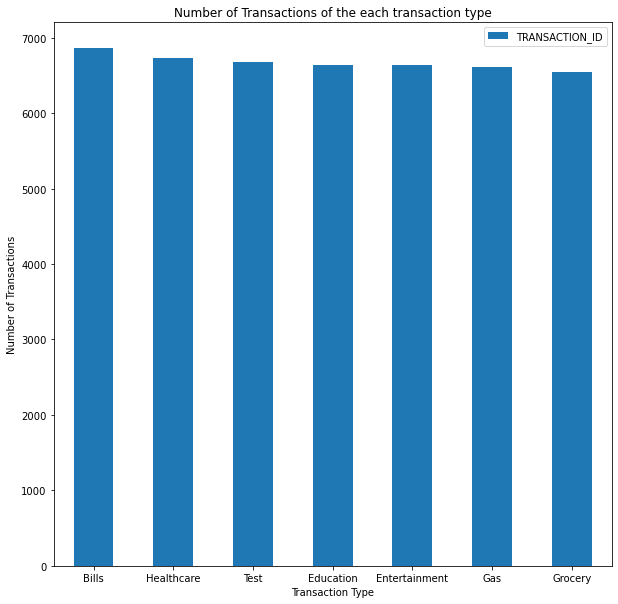

In [80]:
graph1.plot(kind='bar', figsize=(10,10 ), rot=0)

plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions of the each transaction type')

### 3.2  Find and plot states, showing which state has the highest number of customers.

In [41]:
pd_customer = customer.toPandas()
pd_customer.head()

,APT_NO,CREDIT_CARD_NO,CUST_CITY,CUST_COUNTRY,CUST_EMAIL,CUST_PHONE,CUST_STATE,CUST_ZIP,FIRST_NAME,LAST_NAME,LAST_UPDATED,MIDDLE_NAME,SSN,STREET_NAME
0,656,4210653310061055,Natchez,United States,AHooper@example.com,1237818,MS,39120,Alec,Hooper,2018-04-21T12:49:02.000-04:00,Wm,123456100,Main Street North
1,829,4210653310102868,Wethersfield,United States,EHolman@example.com,1238933,CT,06109,Etta,Holman,2018-04-21T12:49:02.000-04:00,Brendan,123453023,Redwood Drive
2,683,4210653310116272,Huntley,United States,WDunham@example.com,1243018,IL,60142,Wilber,Dunham,2018-04-21T12:49:02.000-04:00,Ezequiel,123454487,12th Street East
3,253,4210653310195948,NewBerlin,United States,EHardy@example.com,1243215,WI,53151,Eugenio,Hardy,2018-04-21T12:49:02.000-04:00,Trina,123459758,Country Club Road
4,301,4210653310356919,ElPaso,United States,WAyers@example.com,1242074,TX,79930,Wilfred,Ayers,2018-04-21T12:49:02.000-04:00,May,123454431,Madison Street


In [45]:
graph2 = pd_customer.groupby('CUST_STATE').count()['SSN'].to_frame().sort_values('SSN', ascending = False)
print(graph2)

            SSN
CUST_STATE     
NY           96
GA           73
PA           72
FL           64
IL           58
NJ           53
MD           50
CA           45
MI           44
OH           44
VA           39
NC           37
TX           33
MA           33
SC           30
WI           29
MN           28
MS           24
IA           21
KY           17
WA           16
CT           14
IN           13
MT            9
AR            5
AL            5


Text(0, 0.5, 'Number of Customers')

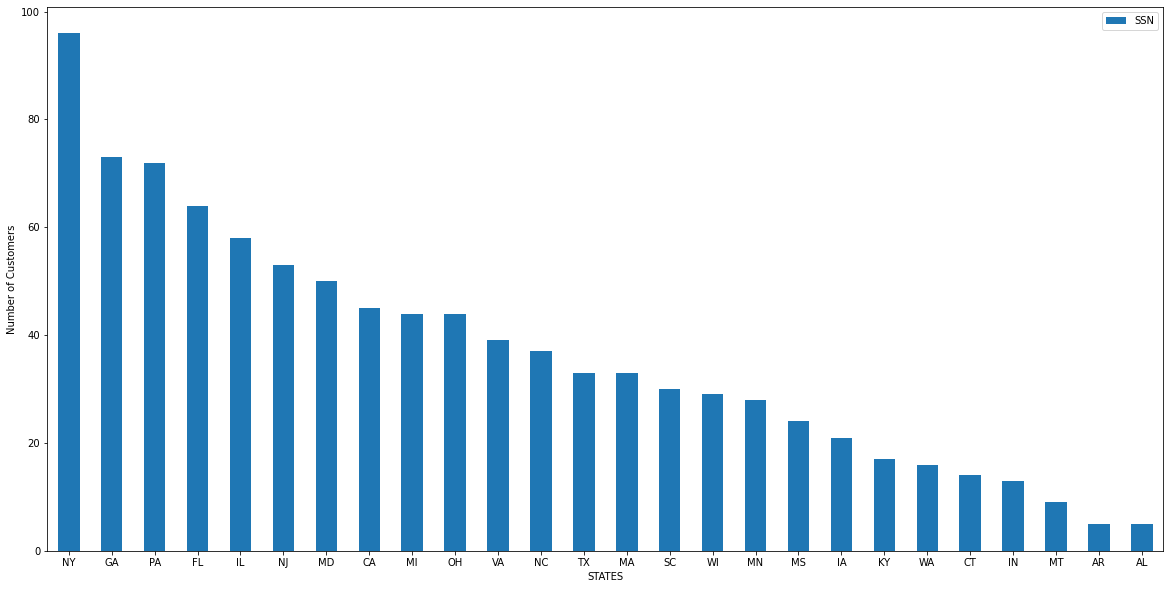

In [77]:
graph2.plot(kind = 'bar' , figsize = (20,10) ,rot=0)
plt.xlabel("STATES")
plt.ylabel("Number of Customers")

In [60]:
pd_credit.head()

,BRANCH_CODE,CREDIT_CARD_NO,CUST_SSN,DAY,MONTH,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,YEAR
0,114,4210653349028689,123459988,14,2,1,Education,78.90,2018
1,35,4210653349028689,123459988,20,3,2,Entertainment,14.24,2018
2,160,4210653349028689,123459988,8,7,3,Grocery,56.70,2018
3,114,4210653349028689,123459988,19,4,4,Entertainment,59.73,2018
4,93,4210653349028689,123459988,10,10,5,Gas,3.59,2018


### 3.3 Find and plot the sum of all transactions for each customer, and which customer has the highest transaction amount. (First 20) hint(use CUST_SSN).



In [68]:
graph3 = pd_credit.groupby('CUST_SSN').sum()['TRANSACTION_VALUE'].to_frame().sort_values( by='TRANSACTION_VALUE',ascending =False).head(20)
graph3

,TRANSACTION_VALUE
CUST_SSN,
123451125,5633.07
123452783,5548.14
123453486,5476.08
123458668,5314.97
123456678,5261.03
123452026,5241.18
123452518,5223.96
123454933,5203.08
123457547,5149.75


Text(0, 0.5, 'Transaction Value')

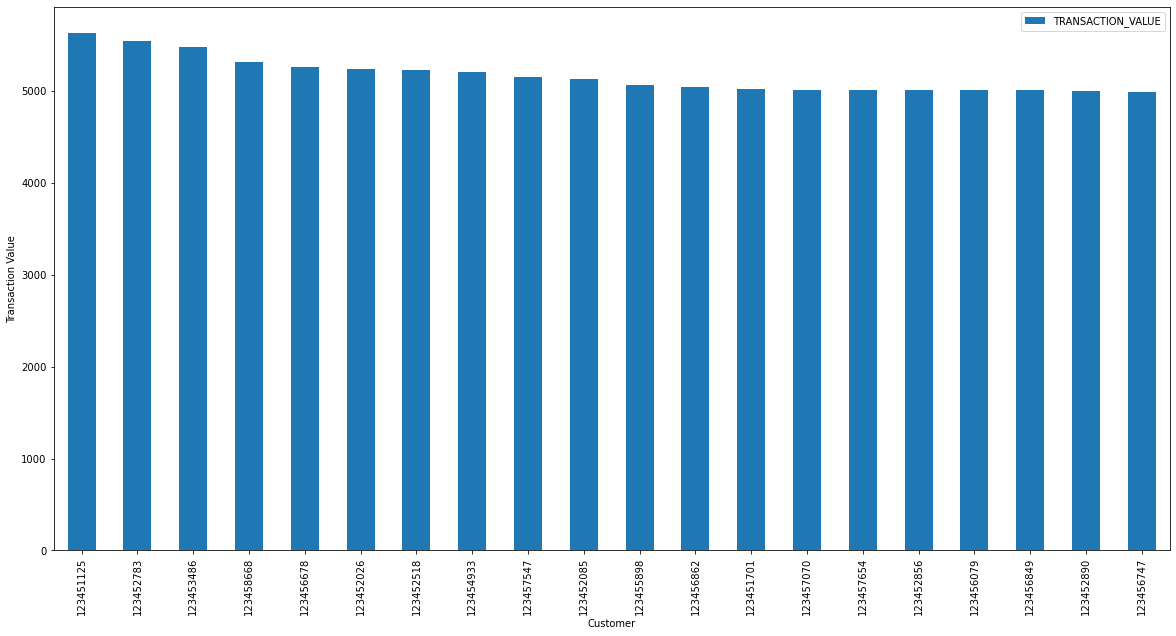

In [85]:
graph3.plot(kind = 'bar' , figsize = (20,10) ,rot=90)
plt.xlabel("Customer")
plt.ylabel("Transaction Value")

### 3.4 Find and plot the top three months with the largest transaction data.


Text(0, 0.5, 'Transaction Value')

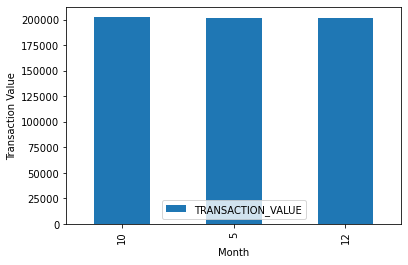

In [86]:
graph4 = pd_credit.groupby('MONTH').sum()['TRANSACTION_VALUE'].to_frame().sort_values( by='TRANSACTION_VALUE',ascending =False).head(3)
graph4

graph4.plot(kind = 'bar' )
plt.xlabel("Month")
plt.ylabel("Transaction Value")

### 3.5 Find and plot each branches healthcare transactions, showing which branch  processed the highest total dollar value of healthcare transactions.



In [89]:
pd_credit[pd_credit['TRANSACTION_TYPE'] == 'Healthcare']

,BRANCH_CODE,CREDIT_CARD_NO,CUST_SSN,DAY,MONTH,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,YEAR
27,43,4210653349028689,123459988,6,8,28,Healthcare,98.78,2018
32,117,4210653349028689,123459988,20,10,33,Healthcare,24.37,2018
43,36,4210653349028689,123459988,13,11,44,Healthcare,79.91,2018
44,124,4210653349028689,123459988,8,9,45,Healthcare,20.81,2018
48,69,4210653349028689,123459988,26,8,49,Healthcare,26.34,2018
...,...,...,...,...,...,...,...,...,...
46633,66,4210653375981317,123451012,17,2,46634,Healthcare,10.03,2018
46675,2,4210653344660822,123451007,18,10,46676,Healthcare,70.01,2018
46680,38,4210653344660822,123451007,27,10,46681,Healthcare,72.78,2018
46686,63,4210653344660822,123451007,22,12,46687,Healthcare,5.56,2018


Text(0, 0.5, 'TRANSACTION VALUE')

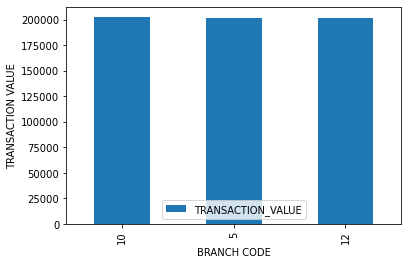

In [91]:
graph5 = pd_credit[pd_credit['TRANSACTION_TYPE'] == 'Healthcare'].groupby('BRANCH_CODE').sum()['TRANSACTION_VALUE'].to_frame().sort_values( by='TRANSACTION_VALUE',ascending =False)
graph5

graph4.plot(kind = 'bar' )
plt.xlabel("BRANCH CODE")
plt.ylabel("TRANSACTION VALUE")

## 4. Functional Requirements - LOAN Application Dataset
